# Wishart Distribution

In [43]:
import jax
import math
import jax.numpy as jnp
from jax import scipy
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from matplotlib.patches import Ellipse
import seaborn as sns

try:
    from probml_utils import savefig, latexify
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify

In [44]:
latexify(fig_height=2.5)

/home/tensorboy/dev/env/lib/python3.8/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [45]:
def wishart_sample(dof, sigma, nsamples, seed=4):
    keys = jax.random.split(jax.random.PRNGKey(seed), num=nsamples)
    d = jnp.size(sigma, 0)
    C = jnp.linalg.cholesky(Sigma)
    S = jnp.zeros((d, d, nsamples))
    for i in range(nsamples):
        t = jax.random.normal(keys[i], shape=(dof, d))
        Z = jnp.matmul(t, C)
        S = S.at[:, :, i].set(jnp.matmul(Z.T, Z))
    return S

In [46]:
def gamma_log_prob(a, b, X):
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
    # a=shape, b=rate=1/scale
    logZ = scipy.special.gammaln(a) - jnp.multiply(a, jnp.log(b))
    logp = jnp.multiply((a - 1), jnp.log(X)) - jnp.multiply(b, X) - logZ
    return logp

In [47]:
def get_cov_ellipse(cov, centre, nstd):
    eigvals, eigvecs = jnp.linalg.eigh(cov)

    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    vx, vy = eigvecs[:, 0][0], eigvecs[:, 0][1]
    theta = jnp.arctan2(vy, vx)
    theta = math.degrees(theta)
    width, height = 2 * nstd * jnp.sqrt(eigvals)

    return width, height, theta

In [53]:
# Plots of some samples from Wishart distribution:
def plot_wishart_distribution_samples(nr, nc, S, dof):
    fig, ax = plt.subplots(
        nr,
        nc,
        sharex=True,
        sharey=True,
    )
    mu = jnp.array([0, 0])
    j = 0
    for r in range(nr):
        for c in range(nc):
            w, h, theta = get_cov_ellipse(S[:, :, j], mu, nstd=3)
            j = j + 1

            ell = Ellipse(xy=mu, width=w, height=h, angle=theta, ec="black", fc="none")  # facecolor='none'
            ax[r, c].add_patch(ell)
            ax[r, c].set_aspect("equal")
            ax[r, c].set_xlim(-25, 25)
            ax[r, c].set_ylim(-25, 25)
            ax[r, c].autoscale()
            ax[r, c].plot(mu[0], mu[1], marker="x")

    sns.despine()
    plt.tight_layout()
    fig.subplots_adjust(top=0.78)

    plt.setp(ax, xlim=(-17, 17), ylim=(-10, 10))
    savefig("wishart_samples")
    plt.show()

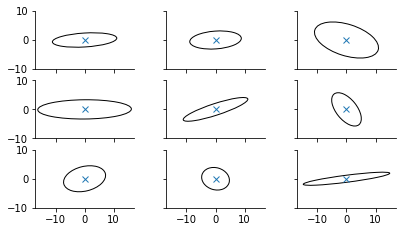

In [54]:
nr = 3
nc = 3
nsamples = 9


S = jnp.array([[3.1653, -0.0262], [-0.0262, 0.6477]])
dof = 3
Sigma = S

Xs1 = jnp.linspace(0.1, 200, 2000)
Xs2 = jnp.linspace(0.1, 40, 400)
Xs3 = jnp.linspace(0.1, 10, 100)
Xsa = {0: Xs1, 1: Xs2}
Xsb = {0: Xs2, 1: Xs3}


M = dof * Sigma
R = jnp.corrcoef(M)
S = wishart_sample(dof, Sigma, nsamples)
plot_wishart_distribution_samples(nr, nc, S, dof)

In [55]:
latexify(width_scale_factor=3, fig_height=1.5)

/home/tensorboy/dev/env/lib/python3.8/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


## Plots of marginals


In [51]:
def plot_marginals(marg1a, marg1b, marg2a, marg2b, Xs1, Xs2):
    logp = gamma_log_prob(marg1a, marg1b, Xs1)
    expo = jnp.exp(logp)

    plt.figure()
    plt.plot(Xs1, expo)
    plt.xlabel(r"$\sum_{11}$")
    plt.ylabel(r"$p(\sum_{11})$")
    sns.despine()
    savefig("wishart_sigma1")
    plt.show()

    logp = gamma_log_prob(marg2a, marg2b, Xs2)
    expo = jnp.exp(logp)

    plt.figure()
    plt.plot(Xs2, expo)
    plt.xlabel(r"$\sum_{22}$")
    plt.ylabel(r"$p(\sum_{22})$")
    sns.despine()
    savefig("wishart_sigma2")
    plt.show()


def plot_correlation_coefficient(nsamples, Rs):

    for s in range(nsamples):
        Rs = Rs.at[:, :, s].set(jnp.corrcoef(Rs[:, :, s]))
    data = jnp.squeeze(Rs[0, 1, :])

    kde = KernelDensity(bandwidth=1.0, kernel="gaussian")
    kde.fit(data.reshape(-1, 1))
    x = jnp.linspace(data.min() - 2, data.max() + 2, 100)
    logprob = kde.score_samples(x[:, None])

    plt.figure()
    plt.xlabel(r"$\rho$")
    plt.ylabel(r"$p(\rho)$")
    plt.plot(x, jnp.exp(logprob))
    sns.despine()
    savefig("wishart_rho")
    plt.show()

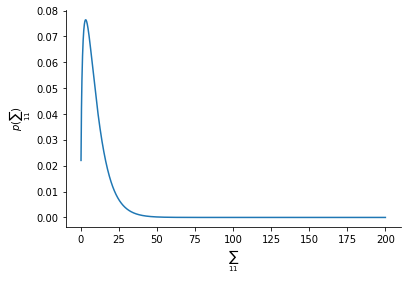

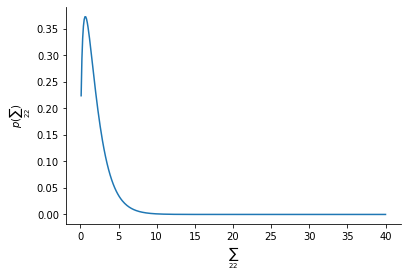

/home/tensorboy/dev/env/lib/python3.8/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


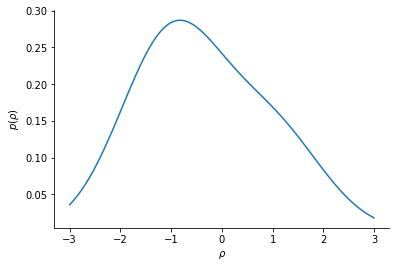

In [52]:
marg1a = dof / 2
marg1b = 1 / (2 * Sigma[0, 0])
marg2a = dof / 2
marg2b = 1 / (2 * Sigma[1, 1])

Rs = wishart_sample(dof, Sigma, nsamples)

plot_marginals(marg1a, marg1b, marg2a, marg2b, Xs1, Xs2)
plot_correlation_coefficient(nsamples, Rs)